# Advanced example: multi-band photometry and masked arrays

**Note:** This notebook presents an example of advanced use of the `photutils.isophote` package. If you didn't read the other notebboks and are not familiar with this kind of analysis, we recommend you do so before tackling this script. 

In this example, we want to build a color profile of a galaxy using two images taken with different filters. One has a higher S/N ratio than the other. We run the `Ellipse` fitting on the high-S/N image, and then, using the derived isophotes, get data for matching isophotes on the low-S/N image at the corresponding positions, but without fitting. In that way, we can directly compare the photometry between the two isophote lists.

In this example we use public domain images of NGC1068 from the Hubble Space Telescope archive (https://www.spacetelescope.org/projects/fits_liberator/ngc1068data/). 

The high-S/N image is a wide-band near-IR image, the other is a narrow-band H$\alpha$ + [NII] image. Due to the detector shapes, the image frames contain extensive regions with no meaningful information in them. These regions have to be masked out. The `photutils.isophote` package can handle `numpy` masked arrays, thus we build masked image frames before submitting them for analysis.

Note that the use of masked arrays slows down the computations quite significantly. This entire script takes ~40 min. to finish on a Mac Pro 3.7 GHz Xeon E5.

### Procedure

1. Fit isophotes on the higher S/N wide band image. This creates a list of `Isophote` instances.

2. Loop over the list and extract the geometry of these isophotes, one by one. 

3. For each value of the semimajor axis (`sma`) and other geometrical parameters in that isophote, extract a matching sample from the low-S/N image, without fitting.

4. Store this sample as a new `Isophote` instance in a second list.

This procedure will avoid fitting problems on the low-S/N image, allowing it to be sampled at regions where the fitting algorithm wouldn't be able to perform meaningful fits.

The end product of this procedure is a set of two `IsophoteList` instances, one for each image. Corresponding `Isophote` instances in each list will match geometrically, thus direct comparison of their photometry can be made. Specifically, we can directly plot the radial dependency of the ratio of intensities in the narrow- and wide-band images. 

### 1. Read images and mask unwanted regions

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

baseurl = 'https://www.spacetelescope.org/static/projects/fits_liberator/datasets/ngc1068/'
url1 = baseurl + '791wmos.zip'

path = download_file(url1)
hdu = fits.open(path)
data_wide = hdu[0].data
hdu.close()

url2 = baseurl + '658nmos.zip'
path = download_file(url2)
hdu = fits.open(path)
data_narrow = hdu[0].data
hdu.close()

(0, 1600)

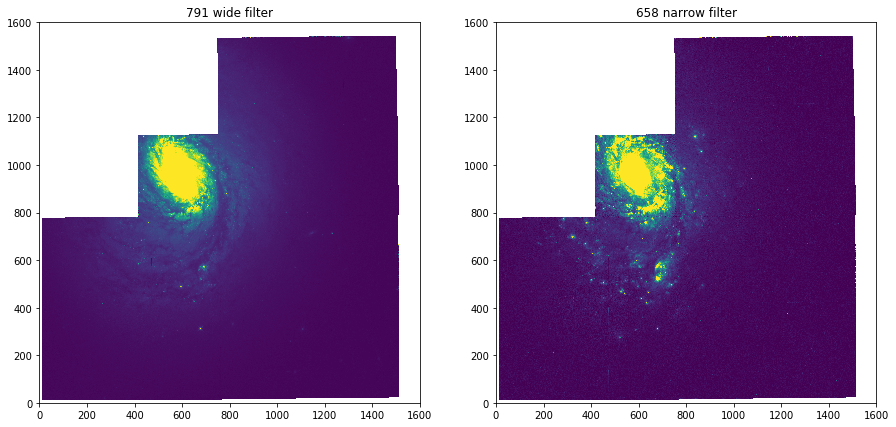

In [2]:
# build numpy masked arrays. In these images, pixels with no 
# information in then are signaled by the value zero. We use 
# that to build the masks.
import numpy as np
import numpy.ma as ma

data_wide = ma.masked_equal(data_wide, np.zeros(shape=data_wide.shape))
data_narrow = ma.masked_equal(data_narrow, np.zeros(shape=data_narrow.shape))

# visually inspect the images.
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
limits = [0, 1600]
ax1.imshow(data_wide, vmin=0, vmax=400)
ax1.set_title("791 wide filter")
ax1.set_xlim(limits)
ax1.set_ylim(limits)

ax2.imshow(data_narrow, vmin=0, vmax=50)
ax2.set_title("658 narrow filter")
ax2.set_xlim(limits)
ax2.set_ylim(limits)

### 2. Start a basic ellipse-fitting procedure on the high-S/N image

This usually requires some trial and error in order to evaluate the abilities of the algorithms regarding the particular image being analysed. In this case, we want to see how far out on the high-S/N image the ellipse-fitting algorithm will go before significance is lost.

In [3]:
from photutils.isophote import EllipseGeometry, Ellipse

# we start with first guesses for the geometry parameters
# gleaned from visual inspection of the image itself.
x0 = 590.    # center position
y0 = 970.    # center position
sma = 100.   # starting semi-major axis length in pixels
eps = 0.3    # ellipticity
pa = 120. / 180. * np.pi  # position angle

g = EllipseGeometry(x0, y0, sma, eps, pa)
g.find_center(data_wide)
ellipse = Ellipse(data_wide, geometry=g)

INFO: Found center at x0 = 586.0, y0 = 965.0 [photutils.isophote.geometry]


For the actual fit, we use default parameter values, except that we use 'median' integration mode, sigma-clipping of the integrated values, and a more lax criterion for the flagged data points. This choice of parameters should probably decrease the influence of bright stars and HII regions on the basically elliptical underlying light distrubution. It will also allow ellipses be fitted even though we have large regions masked out of the image.

In [4]:
# this step will take a long time (> 10 min) to run
isolist_wide = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.3)

/Users/busko/Projects/software/miniconda3/envs/jdaviz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/busko/Projects/software/miniconda3/envs/jdaviz/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/busko/Projects/software/miniconda3/envs/jdaviz/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/busko/Projects/software/miniconda3/envs/jdaviz/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/busko/Projects/software/miniconda3/envs/jdaviz/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
isolist_wide.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,25366.784850481374,0.0,0.0,0.0,0.0,0.0,0.0,None,None,585.6545582238346,0.0,961.4837803467767,0.0,1,0,0,0
0.5289350131014788,25367.68864914872,0.7860629275116814,0.95,0.014954957881731271,61.250669188524995,0.7776298367955687,3.9699239647171924,None,None,585.6545582238346,0.03831004117453323,961.4837803467767,0.06962055428088074,12,1,50,2
0.5818285144116268,25367.951128121756,0.9512762360954774,0.95,0.015420751975989043,61.250669188524995,0.8021095501697255,4.466851309148576,None,None,585.6545582238346,0.043456032631211367,961.4837803467767,0.07897230301133333,12,1,50,2
0.6400113658527895,25368.27599580442,1.164662977267478,0.95,0.019902741377087838,61.250669188524995,1.035155773918097,4.010777110576181,None,None,585.6545582238346,0.061693986539452704,961.4837803467767,0.11211583067055571,12,1,50,2
0.7040125024380685,13392.259084490857,223.33708020816383,0.3794075583380134,0.34289862393845116,110.0995733343677,34.12062445548972,-70.84851152687132,4720.073142346746,66.62205091713922,588.3209465714659,0.13808467054801393,957.9492279198599,0.18823604261545185,13,0,37,5
0.7744137526818753,25376.84731541114,4.964415237824638,0.95,0.019120570687194232,55.67439708419281,1.1726831762198235,13.894152072210938,None,None,585.5027451121857,0.08389850933021308,961.3519385370005,0.12258244730746329,13,0,50,2
0.8518551279500629,25334.138843215653,9.968111655370889,0.49397755417831557,0.008692407743827657,55.67439708419281,0.7148890767136656,-648.3204242879492,288.76761439467685,0.44540878796442446,585.5027451121857,0.005262571539706943,961.3519385370005,0.0064488838080569615,13,0,50,2
0.9370406407450692,25308.836156014044,15.227028626307725,0.49397755417831557,0.010266155733325698,61.391461775313836,0.844286851432073,-859.7949104718913,290.50582097654046,0.33787804212181105,585.5027451121857,0.006404968103074907,961.3519385370005,0.008711793462228267,13,0,18,0


Note that the fit won't proceed beyond `sma~240`. The condition is signaled by the `numpy` warnings above, and by the stop code $5$ at `sma=259` and beyond. Something in the image there prevents the algorithm to ever find a satisfactory solution. 

Note also that the central peak measurement (last row above) looks wrong. It's probably a side effect of the previous fits failures at `sma ~< 1`.

Lets plot some isophotes on top of the image:

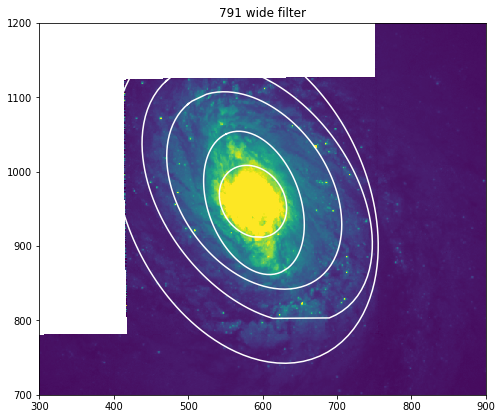

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data_wide, vmin=0, vmax=1200)
ax.set_title("791 wide filter")
ax.set_xlim([300, 900])
ax.set_ylim([700, 1200])

# go to the outermost successfully fitted ellipse at sma=235
isos = []
for sma in [50., 100., 150., 200., 235.]:
    iso = isolist_wide.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='w')

Lets plot some samples:

Text(0, 0.5, 'Intensity')

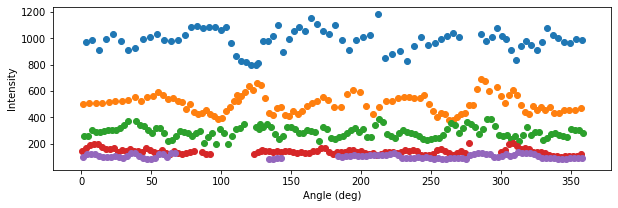

In [7]:
plt.figure(figsize=(10, 3))

for iso in isos:
    angles = ((iso.sample.values[0] + iso.sample.geometry.pa) / np.pi*180.) % 360.
    plt.scatter(angles, iso.sample.values[2])
    
plt.xlabel("Angle (deg)")
plt.ylabel("Intensity")

These plots suggest that the basic elliptical component of the light distribution was accounted for by the fit. No significant first or second order harmonics seem to be present. The remaining oscillations in these residuals are a sign of non-elliptical components still remaining in the image, as expected from such a galaxy.

### 3. Fit outer regions of the galaxy

From the image display we can see that there is still plenty of signal outside `sma=235` to perform reasonable fits. In a situation like this, we can try to resume the fit past the problematic region. We run the fit from a new instance of the `Ellipse` class, initialized with geometry parameters gleaned visually from the outer regions of the galaxy. We also use a larger `step` parameter so as to increase the distance between successive ellipses. This has the benefit of increasing the areas of integration used to extract each data point along a elliptical path, thus improving the S/N ratio. 

In [8]:
# this step will take a long time to run
x0 = 600. 
y0 = 970.
sma = 300.    # start from here, and use this as the minimum sma to fit as well.
eps = 0.2
pa = 70. / 180. * np.pi
g = EllipseGeometry(x0, y0, sma, eps, pa)
g.find_center(data_wide)
ellipse = Ellipse(data_wide, geometry=g)
isolist_wide_outer = ellipse.fit_image(integrmode='median', step=0.3, minsma=300.,
                                       maxsma=1000., fflag=0.3, sclip=3.0, nclip=3)

INFO: Found center at x0 = 605.0, y0 = 965.0 [photutils.isophote.geometry]


In [9]:
isolist_wide_outer.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
230.76923076923075,110.79243965148926,1.9409255709217448,0.29756114456254446,0.004923127718207126,102.86091087631152,0.3364594345690457,-0.693388769944509,0.10720168012917636,0.15460544614496072,596.398831984242,0.36883486627213696,979.7773554022085,1.0170243320864265,100,27,10,0
300.0,58.37344499843343,0.7693064565366358,0.09396031714287592,0.03236476765343537,46.41833833056773,2.9317068183174615,-0.16432793855676356,0.02866671853150387,0.17444823310797858,619.0351801481954,10.276869330577899,918.2836657268512,9.78604093215411,79,48,20,0
390.0,44.239998334719814,0.6205430175952081,0.09396031714287592,0.0037083822716178086,94.86351594836884,3.6258154776890628,-0.17496632679581633,0.02174624344538973,0.1242881635777114,619.0351801481954,2.827114185103938,918.2836657268512,3.6944556181657084,81,46,10,0
507.0,35.958955177894005,0.37796229922285357,0.20053990236339417,0.004429711862568297,86.23311850646937,1.5349516221843442,-0.11600767998187031,0.009002177764136877,0.07759984309266195,597.5106262591058,5.440628112045744,1003.3769204662841,3.453904235803729,78,49,10,0
659.1,18.851687145233154,0.07262085345936216,0.20053990236339417,0.0010280021992887533,66.1196961343319,0.24068544038231235,-0.059820468150953814,0.0021092373762553844,0.03525945953704064,605.6687027394452,1.2018177407579307,930.4863157119862,0.747861996972336,80,47,10,0
856.83,10.224643768802766,0.04026587327901958,0.12962732953301362,0.00994353905064032,78.79757248215523,4.63180472026648,-0.018174824749844838,0.0008261947419731447,0.04545819579251779,558.9655869856681,44.472940937964964,949.7211544390466,19.64428102924853,62,65,10,0


The fit went well down to the edge of the usable data. Comparing the isophote plots below with the plots for the inner region, we can see that there seems to be a sudden change in geometry at around `sma~300`. Ellipses get rounder and the position angle twists by a significant amount at that region, which may explain why the fit there was problematic on the first try.

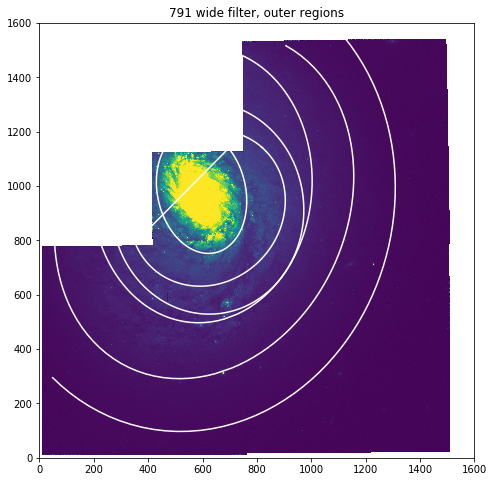

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data_wide, vmin=0, vmax=400)
ax.set_title("791 wide filter, outer regions")
ax.set_xlim(limits)
ax.set_ylim(limits)
isos = []
for sma in [230., 300., 400., 500., 700., 900.]:
    iso = isolist_wide_outer.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')

The plot below also confirms that the fit went well. There is no suggestion that strong first and second harmonics are present after the fit.

Text(0, 0.5, 'Intensity')

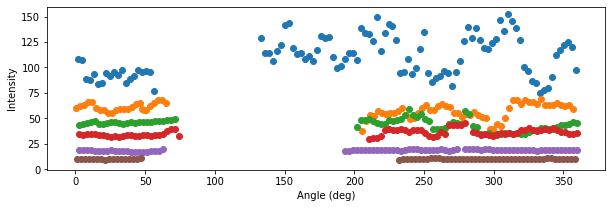

In [11]:
plt.figure(figsize=(10, 3))

for iso in isos:
    angles = ((iso.sample.values[0] + iso.sample.geometry.pa) / np.pi*180.) % 360.
    plt.scatter(angles, iso.sample.values[2])
    
plt.xlabel("Angle (deg)")
plt.ylabel("Intensity")

### 4. Combine results from the inner and outer regions

Now we merge results from the two fits into a single instance of `IsophoteList`. At the same time, we discard the bad fits. Note that the `IsophoteList` instance can be handled in just the same way as any regular python `list`. It supports slicing, concatenation, insert/append, and sorting.

In [12]:
isolist_wide = isolist_wide[7:-2] + isolist_wide_outer

### 5. Add central peak measurement

In the combination above, we discarded the suspiciously-looking central peak measurement. Lets try to get a better measurement. 

(950, 970)

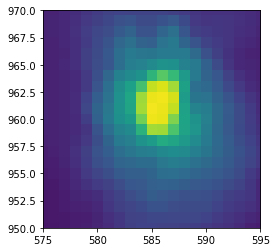

In [13]:
# display central region so we can have a better estimate of the peak's position.
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(data_wide, vmin=0, vmax=26000)
ax.set_xlim([575, 595])
ax.set_ylim([950, 970])

Now, we use the subclasses in the `isophote` package that are dedicated to handling the central peak.

In [14]:
from photutils.isophote.sample import CentralEllipseSample
from photutils.isophote.fitter import CentralEllipseFitter

# central peak position gleaned from the above display.
g = EllipseGeometry(586., 962., 0.0, 0., 0.)

# we use the find_center method to fine tune and confirm our
# choice of central pixel. 
g.find_center(data_wide)

# then we build a CentralEllipseSample instance and call the 
# CentralEllipseFitter on it.
sample = CentralEllipseSample(data_wide, 0., geometry=g)
fitter = CentralEllipseFitter(sample)
center = fitter.fit()
print(center)

INFO: Found center at x0 = 586.0, y0 = 962.0 [photutils.isophote.geometry]
sma    intens    intens_err ellipticity ... ndata flag niter stop_code
                                        ...                           
--- ------------ ---------- ----------- ... ----- ---- ----- ---------
0.0 25485.390625        0.0         0.0 ...     1    0     0         0


Finally, we add the central "isophote" to the list, and sort it so it looks neat. Note that the `fitter.fit()` method call above always returns an instance of `Isophote` or a subclass. The `center` object in the code above can thus be directly added to the `isolist_wide` `IsophoteList` instance.

In [15]:
isolist_wide.append(center)
isolist_wide.sort()

This is the final product for the high-S/N image: 

In [16]:
isolist_wide.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,25485.390625,0.0,0.0,0.0,0.0,0.0,0.0,None,None,586.0,0.0,962.0,0.0,1,0,0,0
0.9370406407450692,25308.836156014044,15.227028626307725,0.49397755417831557,0.010266155733325698,61.391461775313836,0.844286851432073,-859.7949104718913,290.50582097654046,0.33787804212181105,585.5027451121857,0.006404968103074907,961.3519385370005,0.008711793462228267,13,0,18,0
1.0307447048195761,25258.478554164907,19.39420479986633,0.47130842956145724,0.012388401403466972,74.5037532903842,1.0519679602510854,-865.1649617032283,359.19292116392745,0.4151727555595796,585.4990257664459,0.007307969139599687,961.2646057055316,0.011796347480201426,13,0,10,0
1.1338191753015339,25211.85190329423,23.209308246162188,0.4891356405317052,0.011930182716507592,80.24861302756925,0.9878653784909627,-944.2989564249126,364.77401264845685,0.3862908141183172,585.4935616223233,0.007449294389922839,961.2011658382212,0.013129742405736618,13,0,10,0
1.2472010928316872,25144.062198491392,25.44591461449655,0.5080373094267918,0.008837731512222563,82.05912510334018,0.7133324560326478,-1224.1619835472197,339.0532988986386,0.27696767540205214,585.5075493004127,0.0059959727222975955,961.175198900682,0.011144389484354277,13,0,10,0
1.371921202114856,24987.43897986931,29.210555072515085,0.49513597270985366,0.0088711813218376,81.1506427328852,0.7282525428497105,-1306.5499262297922,368.7452792899859,0.28222823474801684,585.5423341850635,0.0066680393090755045,961.2237644070714,0.011965234401982806,13,0,10,0
1.5091133223263415,24771.198630749557,40.07469724416511,0.4691288103064307,0.0101688914620474,80.6058724337472,0.8663640532079518,-1493.9630997738982,427.15249503806535,0.28591903983619954,585.5828893581144,0.008402792824985598,961.2691268009202,0.014348087658297181,13,0,10,0
1.6600246545589756,24490.610592793928,55.701074645764095,0.4358918217288075,0.009947690054673648,79.15365888418077,0.8927027309023531,-2040.9953729209337,540.7631800476885,0.26495071337363446,585.6340939335405,0.009069396231486188,961.3418597258565,0.01449559664272212,13,0,10,0


### 6. Plot some diagnostics

As we did in previous tutorials, we plot profiles of some of the isophote parameters to make sure they are OK.

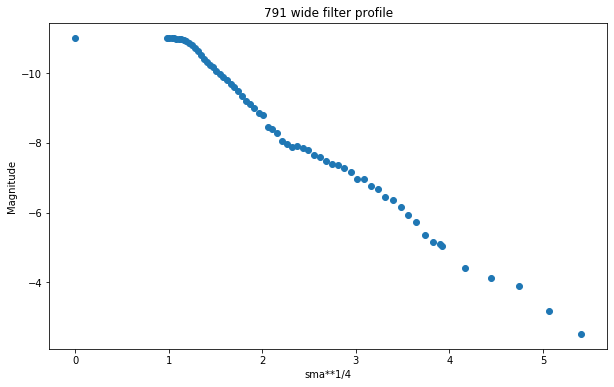

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(isolist_wide.sma**0.25, -2.5*np.log10(isolist_wide.intens))
plt.title("791 wide filter profile")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

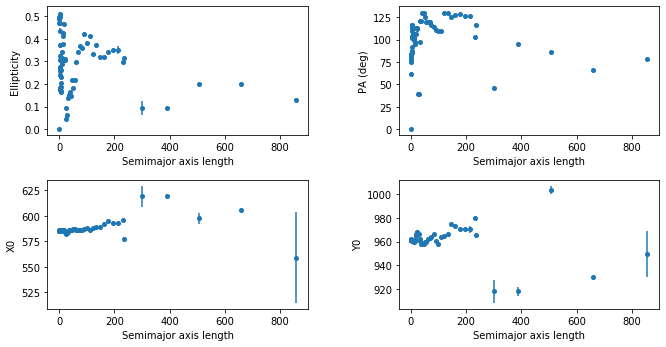

In [18]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist_wide.sma, isolist_wide.eps, yerr=isolist_wide.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist_wide.sma, isolist_wide.pa/np.pi*180., yerr=isolist_wide.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist_wide.sma, isolist_wide.x0, yerr=isolist_wide.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist_wide.sma, isolist_wide.y0, yerr=isolist_wide.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

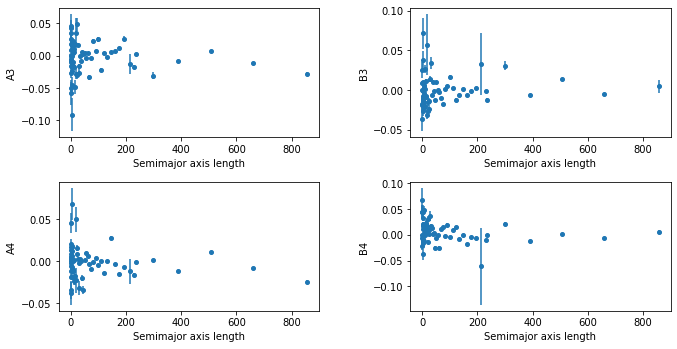

In [19]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist_wide.sma, isolist_wide.a3, yerr=isolist_wide.a3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A3')

plt.subplot(222)
plt.errorbar(isolist_wide.sma, isolist_wide.b3, yerr=isolist_wide.b3_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('B3')

plt.subplot(223)
plt.errorbar(isolist_wide.sma, isolist_wide.a4, yerr=isolist_wide.a4_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('A4')

plt.subplot(224)
plt.errorbar(isolist_wide.sma, isolist_wide.b4, fmt='o', yerr=isolist_wide.b4_err, markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('B4')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

### 7. Use the isophote list just created to drive the sampling on the low-S/N image

In [20]:
# this step will take a few minutes to run
from photutils.isophote import EllipseSample, Isophote, IsophoteList
from photutils.isophote.isophote import Isophote, IsophoteList

# Temporary list to store instances of Isophote
isolist_narrow_ = []

# Loop over the IsophoteList instance with data from the high-S/N image. 
#
# Note that we skip the first isophote. It's an instance of CentralEllipsePixel, 
# which requires special sampling by the CentralEllipseSample subclass. The 
# loop below is coded to handle regular EllipseSample instances only.
for iso in isolist_wide[1:]:

    # Get the EllipseGeometry of each fitted isophote as determined by 
    # fitting on the high-S/N inage.
    g = iso.sample.geometry

    # Sample the low-S/N image at the same geometry. Use the same integration 
    # mode so as to ensure the same regions in each image are sampled. 
    # Use the same clipping parameters as used in the high-S/N image.
    sample = EllipseSample(data_narrow, g.sma, geometry=g, 
                           integrmode='median', sclip=3.0, nclip=3)
    sample.update(g.fix)

    # Create an Isophote instance with the sample, and store it in 
    # temporary list. Here we are using '0' as the number of iterations,
    # 'True' for the validity status, and '0' for the stop code. These
    # are in fact arbitrary in this context; you could use anything you
    # like.
    iso_ = Isophote(sample, 0, True, 0)
    isolist_narrow_.append(iso_)

# Build the IsophoteList instance with the result.
isolist_narrow = IsophoteList(isolist_narrow_)

In [21]:
print(len(isolist_narrow))

65


We still need to add the central peak's measuremet to the list just built.

### 8. Get central peak measurement on low-S/N image

Lets proceed as in **Step 5** above.

(955, 975)

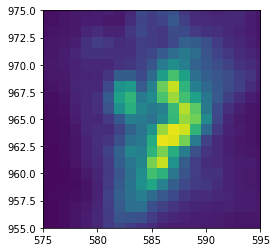

In [22]:
# display central region so we can have a better estimate of the peak's position.
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(data_narrow, vmin=0, vmax=23000)
ax.set_xlim([575, 595])
ax.set_ylim([955, 975])

The peak is ill-defined here. Lets try first with the `find_center` method.

In [23]:
g = EllipseGeometry(587., 962., 0.0, 0., 0.)
g.find_center(data_narrow)

INFO: Found center at x0 = 587.0, y0 = 966.0 [photutils.isophote.geometry]


Apparently the centerer algorithm is not capable of finding the correct peak here. The next best thing would be to see what the `Ellipse` fitting algorithm found in the region that immediately surrounds the peak. **Note:** pixel coordinates in the `photutils.isophote` package are zero-indexed.

In [24]:
for iso in isolist_narrow[0:5]:
    print(iso.sma, iso.x0, iso.y0)

0.9370406407450692 585.5027451121857 961.3519385370005
1.0307447048195761 585.4990257664459 961.2646057055316
1.1338191753015339 585.4935616223233 961.2011658382212
1.2472010928316872 585.5075493004127 961.175198900682
1.371921202114856 585.5423341850635 961.2237644070714


The best position estimate seems to be a combination of what the fit algorithm sees, with what we see in the actual image. Note that this estimate matches the center position found in the high-S/N image within 0.5 pixel.

In [25]:
g = EllipseGeometry(586., 963., 0.0, 0., 0.)
sample = CentralEllipseSample(data_narrow, 0., geometry=g)
fitter = CentralEllipseFitter(sample)
center = fitter.fit()
isolist_narrow.append(center)
isolist_narrow.sort()

This is how the result for the low-S/N image looks like.

In [26]:
isolist_narrow.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,22337.90234375,0.0,0.0,0.0,0.0,0.0,0.0,None,None,586.0,0.0,963.0,0.0,1,0,0,0
0.9370406407450692,18098.100454999287,373.4343695336495,0.49397755417831557,0.03917134766359438,61.391461775313836,3.221517904956628,-1687.6593131683364,5831.6246414955285,3.455451343759361,585.5027451121857,0.02443997799800625,961.3519385370005,0.03324256559585759,13,0,0,0
1.0307447048195761,17914.61656928512,396.70198015798377,0.47130842956145724,0.037450459187386854,74.5037532903842,3.1802627432782473,-2186.3618183283843,5495.998489644506,2.513764393235953,585.4990257664459,0.022093782399906076,961.2646057055316,0.03566810431903239,13,0,0,0
1.1338191753015339,17712.809738837477,401.1291095086847,0.4891356405317052,0.03201931414492654,80.24861302756925,2.650868355265721,-2398.3979874504703,5075.424748483067,2.116172868322956,585.4935616223233,0.019990546650740338,961.2011658382212,0.03523352270183788,13,0,0,0
1.2472010928316872,17508.4566198002,399.92840352086233,0.5080373094267918,0.03013369174645055,82.05912510334018,2.4323694596195113,-2655.977603351944,4637.769965289864,1.746163054777579,585.5075493004127,0.020520922840356667,961.175198900682,0.037998554616027955,13,0,0,0
1.371921202114856,17187.603130569703,401.63633614419143,0.49513597270985366,0.03644576617052255,81.1506427328852,2.992653597096195,-2746.7888577718672,4399.729722236304,1.6017720873548558,585.5423341850635,0.027402392661217603,961.2237644070714,0.04918751191743077,13,0,0,0
1.5091133223263415,16711.356057747533,452.32648775700125,0.4691288103064307,0.04368834542355937,80.6058724337472,3.721909445448203,-2624.510106591402,4677.624849775533,1.7822849445417555,585.5828893581144,0.036107277062466955,961.2691268009202,0.06163996816640654,13,0,0,0
1.6600246545589756,16250.865036527666,597.1682004701229,0.4358918217288075,0.04964356069376298,79.15365888418077,4.45500427468372,-2601.7060792920975,5463.210484884532,2.099856908652428,585.6340939335405,0.04526063300354873,961.3418597258565,0.07233992678890044,13,0,0,0


From above we can spot the very effect we are trying to account for with this elaborate strategy: values of the Gradient Relative Error are typically larger (sometimes not even measurable) in the low-S/N image than in the corresponding isophotes of the high-S/N image.

### 9. Plot diagnostics

The radial profile for the low-S/N image looks like this.

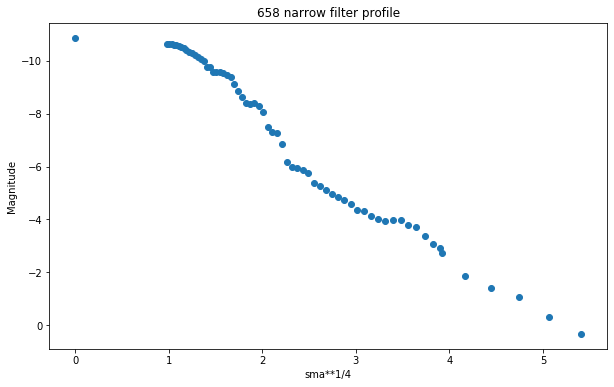

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(isolist_narrow.sma**0.25, -2.5*np.log10(isolist_narrow.intens))
plt.title("658 narrow filter profile")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

### 10. Final result

The main result we are looking for in this script is the radial profile of the (narrow/wide) intensity ratio. It looks like this.

Text(0, 0.5, 'Ratio')

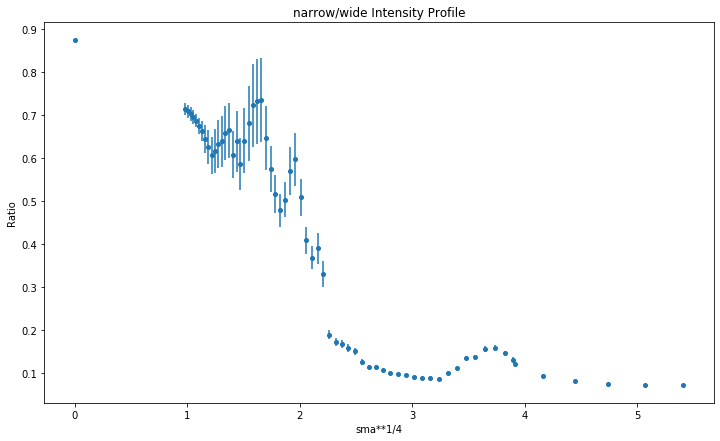

In [28]:
plt.figure(figsize=(12, 7))
# this is an approximation (assumes errors are uncorrelated)
errors = isolist_narrow.intens/isolist_wide.intens * np.sqrt(
    (isolist_narrow.int_err / isolist_narrow.intens)**2 + 
    (isolist_wide.int_err / isolist_wide.intens)**2)
plt.errorbar(isolist_narrow.sma**0.25, (isolist_narrow.intens / isolist_wide.intens),
             yerr=errors, fmt='o', markersize=4)
plt.title("narrow/wide Intensity Profile")
plt.xlabel('sma**1/4')
plt.ylabel('Ratio')

### Disclaimer

The whole point of this script is to showcase how we can use the `photutils.isophote` package algorithms to measure complex sets of images. In no way we intended to do any meaningful science here. The particular choice of images for this exercise was based mostly on their wide availability in the public domain.

As an example on how the "science" here might be easily improved, we note that the very use of sigma-clipping when extracting photometry from the images may counteract the fact that perhaps a good fraction of the total light, in particular in the narrow-band filter, may come from the very [HII] regions we are trying to remove with sigma-clipping in the first place. 

The next level of improvement would probably have to use sigma-clipping and other masking techniques at a first fitting step, to establish once and for all the geometry of the ellipses. Then, using that geometry, extract the photometry without sigma-clipping, using on each one of the images in a double-pass method similar to the procedure we describe here for the two images taken together. 

The procedure outlined in this script was obviously designed for images that precisely overlap, both in position and orientation, as well as plate scale and higher-order geometrical distortions.